Data Processing and Cleaning

In [ ]:
import json
import re

with open("E_comments.txt", "r", encoding="utf-8") as f:
    e_comments = f.read().strip()

with open("E_submission.txt", "r", encoding="utf-8") as f:
    e_submissions = f.read().strip()

with open("EC_comments.txt", "r", encoding="utf-8") as f:
    ec_comments = f.read().strip()

with open("EC_submission.txt", "r", encoding="utf-8") as f:
    ec_submissions = f.read().strip()

def split_comments(text):
    blocks = [b.strip() for b in text.split("\n\n") if b.strip()]
    return blocks

e_comments_list = split_comments(e_comments)
ec_comments_list = split_comments(ec_comments)

def extract_selftexts(text):
    entries = re.findall(r"\{.*?\}", text, flags=re.S)
    selftexts = []
    for entry in entries:
        try:
            obj = json.loads(entry)
            s = obj.get("selftext", "").strip()
            if s and s.lower() not in ["[deleted]", "[removed]"]:
                selftexts.append(s)
        except json.JSONDecodeError:
            continue
    return selftexts

e_selftexts = extract_selftexts(e_submissions)
ec_selftexts = extract_selftexts(ec_submissions)

all_texts = e_comments_list + e_selftexts + ec_comments_list + ec_selftexts

with open("ML_reddit.txt", "w", encoding="utf-8") as out:
    for obs in all_texts:
        out.write(obs.strip() + "\n\n")  

print(f"✅ Combined {len(all_texts)} total observations into ML_reddit.txt")


✅ Combined 315434 total observations into ML_reddit.txt


In [ ]:
with open("ML_reddit.txt", "r", encoding="utf-8") as f:
    text = f.read()

observations = [obs.strip() for obs in text.split("\n\n") if obs.strip()]

print(f"Original: {len(observations)} observations")

cleaned_observations = [
    obs for obs in observations
    if "The above content has been removed" not in obs
]

print(f"After cleaning: {len(cleaned_observations)} observations retained")

with open("ML_clean.txt", "w", encoding="utf-8") as f:
    f.write("\n\n".join(cleaned_observations))



Original: 347798 observations
After cleaning: 346541 observations retained


In [ ]:
import re
from pathlib import Path

input_path = Path("ML_clean.txt")
text = input_path.read_text(encoding="utf-8")

observations = [obs.strip() for obs in re.split(r"\n{2,}", text) if obs.strip()]

print(f"Initial count: {len(observations)}")

def is_meaningful(text):
    t = re.sub(r"&[a-zA-Z0-9#]+;", "", text)
    t = t.replace("\u200b", "").strip().lower()

    if t in {"[removed]", "[deleted]", "removed", "deleted"}:
        return False

    if len(t.split()) < 3:
        return False

    if re.fullmatch(r"(https?://\S+\s*)+", t):
        return False

    if re.search(r"the above content has been removed", t):
        return False

    fillers = [
        "thanks", "thank you", "many thanks", "thanks!", "thank you!", "thank you!!",
        "yes", "yeah", "indeed", "agree", "appreciate it",
        "good post", "great post", "nice", "ok", "okay"
    ]
    for f in fillers:
        if f in t:
            if len(t.split()) < 6:
                return False

    return True

filtered = [obs for obs in observations if is_meaningful(obs)]

filtered = list(dict.fromkeys(filtered))

print(f"After filtering: {len(filtered)} observations retained")

output_path = Path("ML_superclean.txt")
output_path.write_text("\n\n".join(filtered), encoding="utf-8")
print(f"Super-cleaned file saved to: {output_path}")



Initial count: 346541
After filtering: 316986 observations retained
Super-cleaned file saved to: ML_superclean.txt


In [ ]:
import re
from pathlib import Path

input_path = Path("ML_superclean.txt")
text = input_path.read_text(encoding="utf-8")

observations = [obs.strip() for obs in re.split(r"\n{2,}", text) if obs.strip()]

print(f"Loaded {len(observations)} comments from {input_path.name}")

def is_meaningful(text):
    t = re.sub(r"&[a-zA-Z0-9#]+;", "", text)
    t = t.replace("\u200b", "").strip().lower()

    if t in {"[removed]", "[deleted]", "removed", "deleted"}:
        return False

    if len(t.split()) < 3:
        return False

    if re.fullmatch(r"(https?://\S+\s*)+", t):
        return False

    if "the above content has been removed" in t:
        return False

    fillers = [
        "thanks", "thank", "thank you", "many thanks", "appreciate",
        "appreciated", "great", "good", "nice", "awesome", "amazing",
        "wow", "love", "interesting", "cool", "nice read", "great read",
        "good read", "helpful", "insightful", "glad"
    ]

    words = re.findall(r"\b\w+\b", t)
    if not words:
        return False

    filler_count = sum(any(f in w for f in fillers) for w in words)

    if filler_count / len(words) > 0.4:
        return False

    return True


filtered = [obs for obs in observations if is_meaningful(obs)]

filtered = list(dict.fromkeys(filtered))

print(f"After strict filtering: {len(filtered)} comments retained")

output_path = Path("x.txt")
output_path.write_text("\n\n".join(filtered), encoding="utf-8")
print(f"Strictly cleaned file saved to: {output_path.resolve()}")


Loaded 316986 comments from ML_superclean.txt
After strict filtering: 316903 comments retained
Strictly cleaned file saved to: /Users/pangyuxuan/Desktop/psych/ML_new/x.txt


The above x.txt was named as a placeholder, and it was renamed back to "ML_superclean.txt" and used for the following computation.

Statistics

In [29]:
with open("ML_superclean.txt", "r", encoding="utf-8") as f:
    comments = [line.strip() for line in f if line.strip()]

print("Total comments:", len(comments))


Total comments: 331322


In [30]:
import pandas as pd

char_lengths = [len(c) for c in comments]
df_char = pd.DataFrame({"char_len": char_lengths})

df_char.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.99])


,char_len
count,331322.000000
mean,325.378728
std,498.302823
min,1.000000
25%,71.000000
50%,168.000000
75%,378.000000
90%,752.000000
99%,2384.790000
max,10096.000000


In [31]:
token_lengths = [len(c.split()) for c in comments]
df_tok = pd.DataFrame({"token_len": token_lengths})

df_tok.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.99])


,token_len
count,331322.000000
mean,57.561403
std,86.776515
min,1.000000
25%,13.000000
50%,30.000000
75%,67.000000
90%,133.000000
99%,417.000000
max,1821.000000


In [32]:
all_tokens = " ".join(comments).split()
vocab = set(all_tokens)

print("Vocabulary size:", len(vocab))


Vocabulary size: 401912


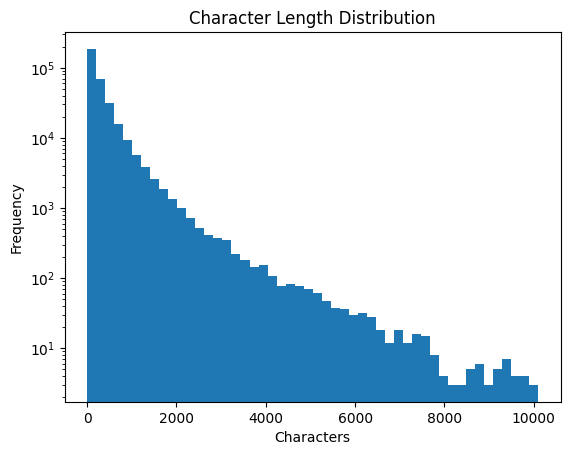

In [34]:
import matplotlib.pyplot as plt

plt.hist(df_char["char_len"], bins=50)
plt.title("Character Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()


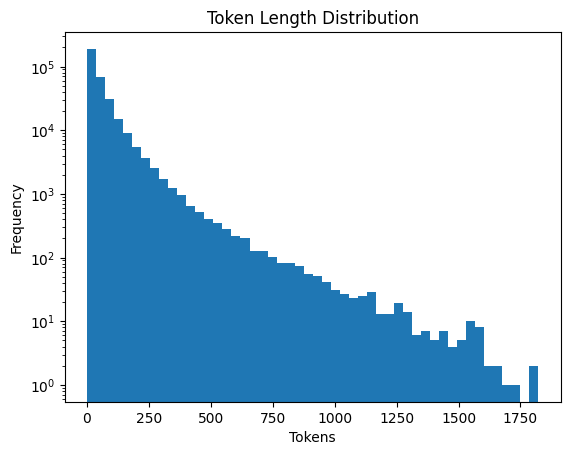

In [35]:
plt.hist(df_tok["token_len"], bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()


Data Visualization: PCA and UMAP

/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWa

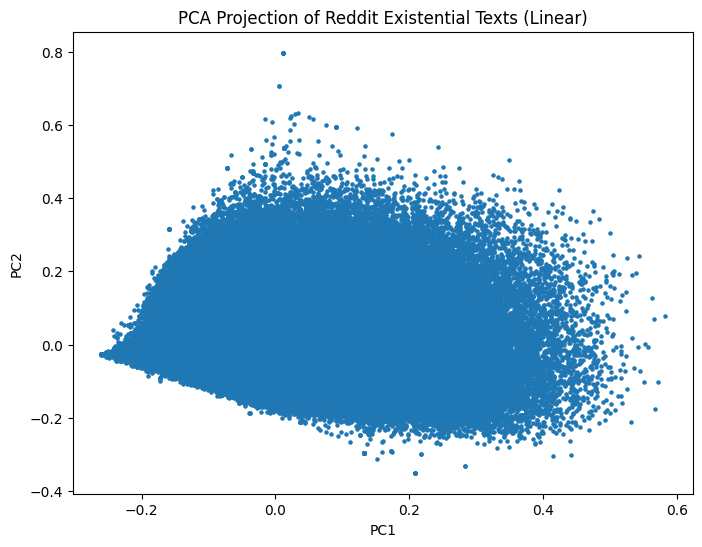

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

with open("ML_superclean.txt", "r") as f:
    texts = [line.strip() for line in f if line.strip()]

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(texts)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=5)
plt.title("PCA Projection of Reddit Existential Texts (Linear)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


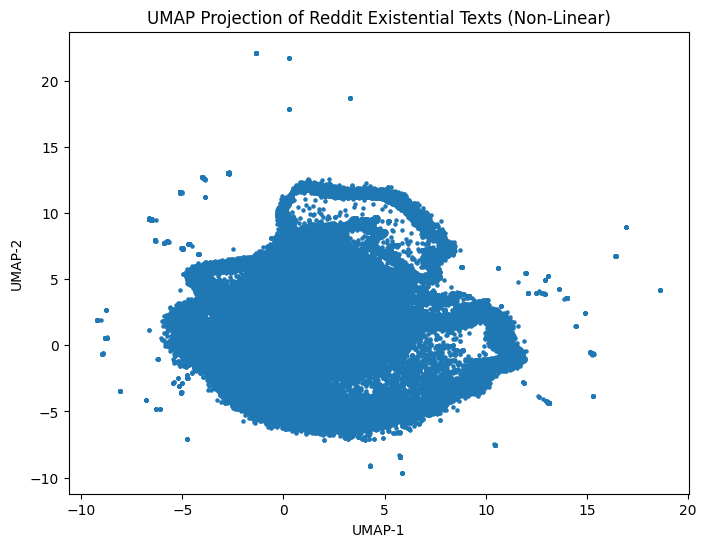

In [26]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], s=5)
plt.title("UMAP Projection of Reddit Existential Texts (Non-Linear)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


Test number of clusters for semantic K-Means (Elbow Method)

/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: Runt

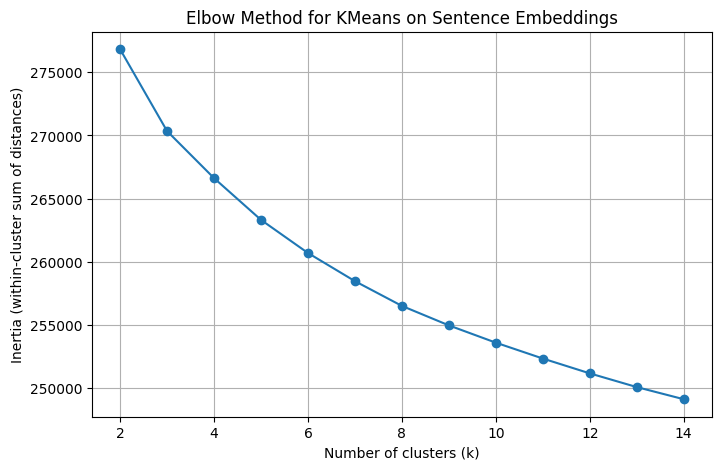

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


inertias = []
cluster_range = range(2, 15)  

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(embeddings)
    inertias.append(model.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8,5))
plt.plot(list(cluster_range), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of distances)")
plt.title("Elbow Method for KMeans on Sentence Embeddings")
plt.grid(True)
plt.show()




Test for number of topics (NMF)

In [ ]:
import re
import html
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

with open("ML_superclean.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

def clean_text(text):
    original = text.strip()
    if not original:
        return None, None

    clean = html.unescape(original)
    clean = re.sub(r"(^|\n)\s*>\s.*", "", clean)
    clean = re.sub(r"http\S+", "", clean)
    clean = re.sub(r"&[a-z]+;", "", clean)
    clean = re.sub(r"\s+", " ", clean).strip()

    return clean if clean else None, original

cleaned_texts = []
for line in lines:
    clean, _ = clean_text(line)
    if clean:
        cleaned_texts.append(clean)

print(f"Total comments kept: {len(cleaned_texts)}")

vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.9,
    min_df=10,
    ngram_range=(1,2),
)
X = vectorizer.fit_transform(cleaned_texts)

n_topics = 5  
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda')
W = nmf_model.fit_transform(X)
H = nmf_model.components_

feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"\n=== Topic {topic_idx+1} ===")
    print(", ".join(top_words))


Total comments kept: 326575


/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat



=== Topic 1 ===
like, feel, feel like, sounds, sounds like, just, feels, feeling, feels like, ve

=== Topic 2 ===
life, meaning, meaning life, purpose, live, meaningless, life meaning, create, living, make

=== Topic 3 ===
know, don, don know, want, don think, don want, just don, know don, understand, think

=== Topic 4 ===
just, think, people, time, way, things, good, god, really, make

=== Topic 5 ===
death, fear, die, fear death, afraid, life, experience, dying, life death, end


/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


After running through topic number = 1 to 7, the optimal topic number is decided to be 6 for NMF.

In [ ]:
# --- NMF code block ---
import re
import html
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

with open("ML_superclean.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

def clean_text(text):
    """
    Remove quoted lines (>), links, and HTML artifacts for modeling,
    but return cleaned + original versions.
    """
    original = text.strip()
    if not original:
        return None, None

    clean = html.unescape(original)

    clean = re.sub(r"(^|\n)\s*>\s.*", "", clean)

    clean = re.sub(r"http\S+", "", clean)

    clean = re.sub(r"&[a-z]+;", "", clean)

    clean = re.sub(r"\s+", " ", clean).strip()

    return clean if clean else None, original

cleaned_texts = []
original_texts = []
for line in lines:
    clean, orig = clean_text(line)
    if clean:
        cleaned_texts.append(clean)
        original_texts.append(orig)

print(f"Total comments kept: {len(cleaned_texts)}")

vectorizer = TfidfVectorizer(
    stop_words='english',    
    max_df=0.9,              
    min_df=10,              
    ngram_range=(1,2),       
)
X = vectorizer.fit_transform(cleaned_texts)

n_topics = 6
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda')
W = nmf_model.fit_transform(X)
H = nmf_model.components_

feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

topic_word_summary = []
for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topic_word_summary.append(f"Topic {topic_idx+1}: " + ", ".join(top_words))

def get_top_comments_for_topic(W, topic_idx, texts, top_n=3):
    top_indices = W[:, topic_idx].argsort()[::-1][:top_n]
    return [texts[i] for i in top_indices]

topic_results = []
for topic_idx in range(n_topics):
    top_comments = get_top_comments_for_topic(W, topic_idx, original_texts)
    topic_results.append({
        "Topic": topic_idx + 1,
        "Top_Words": ", ".join([feature_names[i] for i in H[topic_idx].argsort()[:-n_top_words - 1:-1]]),
        "Representative_Comments": top_comments
    })

output_path = "NMF_output.txt"
with open(output_path, "w", encoding="utf-8") as f:
    for topic in topic_results:
        f.write(f"=== Topic {topic['Topic']} ===\n")
        f.write(f"Top words: {topic['Top_Words']}\n\n")
        f.write("Top 3 representative comments:\n")
        for c in topic['Representative_Comments']:
            f.write(f"- {c}\n\n")
        f.write("\n" + "="*60 + "\n\n")

print(f"NMF topic modeling complete! Results saved to '{output_path}'.")


Total comments kept: 326659


/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


NMF topic modeling complete! Results saved to 'NMF_output.txt'.


Test for number of topics (K-Means TF-IDF)

In [12]:
# === 1. Import libraries ===
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

# === 2. Load cleaned comments ===
input_file = "ML_superclean.txt"

with open(input_file, "r", encoding="utf-8") as f:
    comments = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(comments)} comments")

# === 3. (Optional) Basic filtering ===
def is_meaningful_comment(text):
    t = text.lower().strip()

    if re.search(r"http|www|youtu|reddit|imgur|\.com|\.org", t):
        return False

    if len(t.split()) < 3:
        return False

    return True

filtered_comments = [c for c in comments if is_meaningful_comment(c)]
print(f"Filtered down to {len(filtered_comments)} usable comments")

# === 4. TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.7,
    min_df=5,
    max_features=20000
)

X = vectorizer.fit_transform(filtered_comments)
terms = np.array(vectorizer.get_feature_names_out())

# === 5. Try k = n clusters ===
k = 7
kmeans = MiniBatchKMeans(
    n_clusters=k,
    random_state=42,
    batch_size=2048,
    n_init=10
)
kmeans.fit(X)

print(f"\n K-Means Complete with k = {k}\n")

# === 6. Print top words for each cluster ===
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
top_n = 15

for i in range(k):
    top_words = terms[order_centroids[i, :top_n]]
    print(f"=== Cluster {i+1} ===")
    print(", ".join(top_words))
    print()


Loaded 331322 comments
Filtered down to 315727 usable comments

 K-Means Complete with k = 7

=== Cluster 1 ===
goal, hindu, end, comprehension, struggles, buddhist, passed, hurt, religions, reincarnation, spiritual, beliefs, im, talking, knowledge

=== Cluster 2 ===
shooter, spectator, competitive, round, win, died, game, wish, view, death, know, like, experince, experiment, experimental

=== Cluster 3 ===
life, just, like, don, think, know, people, time, meaning, death, way, feel, things, really, want

=== Cluster 4 ===
articulates, paradox, quote, choice, pain, live, good, time, experts, expertise, expert, experimental, experince, experiments, expierence

=== Cluster 5 ===
free, exist, does, don, important, difference, define, illusion, hope, fear, fundamental, choose, doesn, make, really

=== Cluster 6 ===
quite, sure, understand, mean, don, expierence, experts, expertise, expert, experince, experientially, experiments, expiration, experimenting, experimented

=== Cluster 7 ===
195

After running through k = 1 to 7, the optimal k is decided to be 4 for KMeans.

In [ ]:
# === K-Means Topic Clustering with TF-IDF ===
from pathlib import Path
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


input_path = Path("ML_superclean.txt")
comments = [c.strip() for c in input_path.read_text(encoding="utf-8").split("\n\n") if c.strip()]
print(f"Loaded {len(comments)} comments.")


vectorizer = TfidfVectorizer(
    max_df=0.9,        
    min_df=5,         
    stop_words='english',
    ngram_range=(1, 2), 
)
X = vectorizer.fit_transform(comments)
print(f"TF-IDF matrix shape: {X.shape}")

n_clusters = 6 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X)
labels = kmeans.labels_


terms = np.array(vectorizer.get_feature_names_out())
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

topn = 10  
results = []

for i in range(n_clusters):
    cluster_terms = [terms[ind] for ind in order_centroids[i, :topn]]
    cluster_comments_idx = np.where(labels == i)[0]

    cluster_vectors = X[cluster_comments_idx]
    cluster_center = kmeans.cluster_centers_[i]
    distances = np.linalg.norm(cluster_vectors - cluster_center, axis=1)
    closest_indices = cluster_comments_idx[np.argsort(distances)[:3]]

    representative_comments = [comments[idx] for idx in closest_indices]

    topic_block = f"=== Cluster {i+1} ===\n"
    topic_block += f"Top words: {', '.join(cluster_terms)}\n\n"
    topic_block += "Top 3 representative comments:\n"
    for c in representative_comments:
        topic_block += f"- {c}\n\n"
    topic_block += "=" * 60 + "\n\n"
    results.append(topic_block)


output_path = Path("KMean_output.txt")
output_path.write_text("".join(results), encoding="utf-8")
print(f"K-Means clustering complete! Results saved to '{output_path}'")


Loaded 316986 comments.
TF-IDF matrix shape: (316986, 254182)


/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


: 

In [ ]:
# === Switch to MiniBatchKMeans ===
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

input_file = "ML_superclean.txt"

with open(input_file, "r", encoding="utf-8") as f:
    comments = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(comments)} comments")

def is_meaningful_comment(text):
    t = text.lower().strip()

    if re.search(r"http|www|youtu|reddit|imgur|wikipedia|\.com|\.org", t):
        return False

    fillers = [
        "thanks", "thank you", "many thanks", "thanks!", "thank you!", "thank you!!",
        "yes", "yeah", "indeed", "agree", "appreciate it",
        "good post", "great post", "nice", "ok", "okay", "good", "removed", "x200b", "lol", "tldr"
    ]
    if t in fillers or any(t.startswith(f) for f in fillers):
        return False

    if len(t.split()) < 3:
        return False

    return True

filtered_comments = [c for c in comments if is_meaningful_comment(c)]
print(f"Filtered down to {len(filtered_comments)} comments")

vectorizer = TfidfVectorizer(
    max_df=0.7,        
    min_df=5,          
    stop_words='english',  
    max_features=20000 
)

X = vectorizer.fit_transform(filtered_comments)
print(f"TF-IDF matrix shape: {X.shape}")

num_clusters = 4
kmeans = MiniBatchKMeans(
    n_clusters=num_clusters,
    random_state=42,
    batch_size=2048,
    n_init=10
)
kmeans.fit(X)
print("✅ K-Means clustering complete!")

terms = np.array(vectorizer.get_feature_names_out())
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

output_lines = []
for i in range(num_clusters):
    top_words = terms[order_centroids[i, :15]]
    output_lines.append(f"=== Cluster {i+1} ===")
    output_lines.append("Top words: " + ", ".join(top_words))

    cluster_indices = np.where(kmeans.labels_ == i)[0]
    output_lines.append("Top 3 representative comments:")
    if len(cluster_indices) > 0:
        for idx in cluster_indices[:3]:
            output_lines.append(f"- {filtered_comments[idx][:250]}")
    else:
        output_lines.append("- (No comments assigned)")
    output_lines.append("\n" + "="*60 + "\n")

output_file = "KMean_output.txt"
with open(output_file, "w", encoding="utf-8") as out:
    out.write("\n".join(output_lines))

print(f"💾 Clustered results saved to '{output_file}'")



Loaded 331322 comments
Filtered down to 301482 comments
TF-IDF matrix shape: (301482, 20000)
✅ K-Means clustering complete!
💾 Clustered results saved to 'KMean_output.txt'


Word Embedddings and K-Means

Load Cleaned File (ML_superclean.txt)

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans
import umap
import matplotlib.pyplot as plt

with open("ML_superclean.txt", "r", encoding="utf-8") as f:
    comments = [line.strip() for line in f if line.strip()]

print("Loaded:", len(comments))


/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded: 331322


Load Sentence-BERT Model (all-MiniLM-L6-v2) + Compute Embeddings

In [ ]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = model.encode(comments, batch_size=64, show_progress_bar=True)
embeddings = np.array(embeddings)

print("Embedding matrix shape:", embeddings.shape)


Batches: 100%|██████████| 5177/5177 [07:47<00:00, 11.08it/s]


Embedding matrix shape: (331322, 384)


K-Means Clustering on Embeddings (6 clusters)

In [20]:
num_clusters = 6
kmeans = MiniBatchKMeans(
    n_clusters=num_clusters,
    random_state=42,
    batch_size=2048,
    n_init=20
)

labels = kmeans.fit_predict(embeddings)
print("Clustering complete!")


/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: Runt

Clustering complete!


Extract Representative Comments per Cluster

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

output_lines = []

for i in range(num_clusters):
    output_lines.append(f"=== Cluster {i+1} ===")

    idx = np.where(labels == i)[0]

    center = kmeans.cluster_centers_[i].reshape(1, -1)
    sims = cosine_similarity(center, embeddings[idx])[0]
    top_idx = idx[np.argsort(-sims)[:3]]

    output_lines.append("Top 3 representative comments:")
    for j in top_idx:
        output_lines.append("- " + comments[j][:300])
    output_lines.append("\n" + "="*60 + "\n")


/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pangyuxuan/Desktop/psych/psychenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/pangy

In [14]:
with open("SemanticKMean_output.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(output_lines))

print("Saved output to SemanticKMean_output.txt")


Saved output to SemanticKMean_output.txt
